# Transfer Learning (Resnet50)

In [3]:
import keras.backend as K
from keras.datasets import cifar10
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Conv2D, Activation, BatchNormalization, Flatten, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam, adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, ImageFile
from math import ceil
from sklearn.model_selection import train_test_split
#from tqdm import tqdm_notebook as tqdm
import copy
import json
%matplotlib inline
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,stratify=y_train, test_size=0.3, random_state=2019)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(35000, 32, 32, 3) (35000, 1) (15000, 32, 32, 3) (15000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
num_cls = 10
y_train = to_categorical(y_train, num_cls)
y_valid = to_categorical(y_valid, num_cls)
y_test  = to_categorical(y_test,  num_cls)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(35000, 32, 32, 3) (35000, 10) (15000, 32, 32, 3) (15000, 10) (10000, 32, 32, 3) (10000, 10)


In [4]:
#cols = ['file_path', 'label']
train_df, valid_df = pd.DataFrame(), pd.DataFrame()
test_df = pd.DataFrame()

In [24]:
def utility(img_set, label_set, new_shape=(224, 224),
            dst_dir='/train_imgs', filename='train_id'):
    df = pd.DataFrame(columns=['file_path', 'label'])
    if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
    for i in tqdm(range(len(img_set))):
        tmp_label =  label_set[i].argmax()
        if not os.path.exists(dst_dir +'/'+ str(tmp_label)):
            os.makedirs(dst_dir +'/'+ str(tmp_label))
        
        dst_file = dst_dir+'/'+str(tmp_label)+'/'+filename+'_'+str(i)+'_'+str(tmp_label) +'.jpeg'
        #print(dst_file)
        
        df.loc[i, 'file_path'] = dst_file
        df.loc[i, 'label'] = str(tmp_label)
        tmp = cv2.resize(img_set[i], new_shape)
        tmp = cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR)
        cv2.imwrite(dst_file, tmp)
    return df.copy()

In [25]:
train_df = utility(x_train, y_train, dst_dir='/home/crea/tf_env/train_imgs', filename='train_id')
valid_df = utility(x_valid, y_valid, dst_dir='/home/crea/tf_env/valid_imgs', filename='valid_id')
test_df   = utility(x_test, y_test, dst_dir='/home/crea/tf_env/test_imgs', filename='test_id')

In [8]:
train_df.to_csv('cifar10_df.csv', encoding='utf-8')
valid_df.to_csv('cifar10_df.csv', encoding='utf-8')
test_df.to_csv('cifar10_df.csv', encoding='utf-8')

In [10]:
test_df.head(), train_df.head(), valid_df.head()

(                                       file_path label
 0  /home/crea/tf_env/test_imgs/3/test_id_0_3.png     3
 1  /home/crea/tf_env/test_imgs/8/test_id_1_8.png     8
 2  /home/crea/tf_env/test_imgs/8/test_id_2_8.png     8
 3  /home/crea/tf_env/test_imgs/0/test_id_3_0.png     0
 4  /home/crea/tf_env/test_imgs/6/test_id_4_6.png     6,
                                          file_path label
 0  /home/crea/tf_env/train_imgs/1/train_id_0_1.png     1
 1  /home/crea/tf_env/train_imgs/8/train_id_1_8.png     8
 2  /home/crea/tf_env/train_imgs/6/train_id_2_6.png     6
 3  /home/crea/tf_env/train_imgs/6/train_id_3_6.png     6
 4  /home/crea/tf_env/train_imgs/0/train_id_4_0.png     0,
                                          file_path label
 0  /home/crea/tf_env/valid_imgs/2/valid_id_0_2.png     2
 1  /home/crea/tf_env/valid_imgs/2/valid_id_1_2.png     2
 2  /home/crea/tf_env/valid_imgs/5/valid_id_2_5.png     5
 3  /home/crea/tf_env/valid_imgs/2/valid_id_3_2.png     2
 4  /home/crea/tf_env/va

In [31]:
#create model

K.clear_session()
#using resnet50 imagenet pretrained model
resnet50_model = ResNet50(input_shape=(256, 256, 3), weights='imagenet', pooling='avg', include_top=False)

#fix pretrained parameter
for layer in resnet50_model.layers:
    layer.trainable = False

# new classifier
last_feature_map = resnet50_model.output
x = Dense(512, activation='relu')(last_feature_map)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(num_cls, activation='softmax')(x)
model = Model(inputs=[resnet50_model.input], outputs=[output_layer])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
train_generator = ImageDataGenerator(#featurewise_center=True,
                                     #featurewise_std_normalization=True,
                                     #samplewise_center=True,
                                     #samplewise_std_normalization=True,
                                     #rescale= 1/255.,
                                     preprocessing_function=preprocess_input,
                                     rotation_range=20,
                                     width_shift_range= 0.2,
                                     height_shift_range= 0.2,
                                     data_format='channels_last'
                                     )
test_generator = ImageDataGenerator(
                                    #featurewise_center=True,
                                    #featurewise_std_normalization=True,
                                    #samplewise_center=True,
                                    #samplewise_std_normalization=True
                                    #rescale= 1/255.,
                                    preprocessing_function=preprocess_input,
                                    data_format='channels_last'
                                    )
#train_generator.fit(x_train)
#test_generator.fit(x_test)

In [32]:
BATCH_SIZE = 25
EPOCHS = 100
LEARNING_RATE = 1e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='cifar10.h5', 
                             save_best_only=True, verbose=1)

model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
history = model.fit_generator(train_generator.flow_from_directory('/home/crea/tf_env/train_imgs', 
                                                                  batch_size=BATCH_SIZE),
                                                      
                              epochs=EPOCHS, steps_per_epoch=ceil(len(x_train)/BATCH_SIZE),
                              validation_data= test_generator.flow_from_directory('/home/crea/tf_env/valid_imgs',
                                                                   batch_size=BATCH_SIZE),
                              validation_steps=ceil(len(x_valid)/BATCH_SIZE),
                              verbose=1, callbacks=[lr_reducer, early_stop, checkpoint],
                              shuffle=True)
                              

Found 35000 images belonging to 10 classes.
Found 15000 images belonging to 10 classes.
Epoch 1/100
1400/1400 [==============================] - 350s 250ms/step - loss: 2.0401 - acc: 0.3203 - val_loss: 1.9738 - val_acc: 0.4127

Epoch 00001: val_loss improved from inf to 1.97384, saving model to cifar10.h5
Epoch 2/100
1400/1400 [==============================] - 349s 249ms/step - loss: 1.3711 - acc: 0.5240 - val_loss: 1.4752 - val_acc: 0.5494

Epoch 00002: val_loss improved from 1.97384 to 1.47522, saving model to cifar10.h5
Epoch 3/100
1400/1400 [==============================] - 352s 252ms/step - loss: 1.1878 - acc: 0.5889 - val_loss: 1.3397 - val_acc: 0.5957

Epoch 00003: val_loss improved from 1.47522 to 1.33966, saving model to cifar10.h5
Epoch 4/100
1400/1400 [==============================] - 351s 251ms/step - loss: 1.1067 - acc: 0.6177 - val_loss: 1.1840 - val_acc: 0.6449

Epoch 00004: val_loss improved from 1.33966 to 1.18401, saving model to cifar10.h5
Epoch 5/100
1400/1400 [=

Found 10000 images belonging to 10 classes.
[0.6202231776714325, 0.8083999997377396]


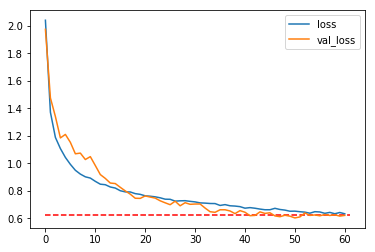

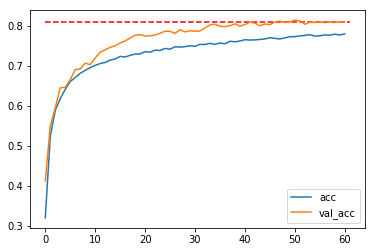

In [54]:
model = load_model('cifar10.h5')
BATCH_SIZE = 100
score = model.evaluate_generator(test_generator.flow_from_directory('/home/crea/tf_env/test_imgs', 
                                                                  batch_size=BATCH_SIZE),
                                                                  ceil(len(x_test)/BATCH_SIZE),
                    
                        )
print(score)

#for k in ['val_acc', 'loss', 'val_loss', 'acc']:
#    with open('history_'+k+'.json', 'w') as f:
#        json.dump(history.history[k], f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
plt.hlines(score[0], 0, len(history.history['loss']), linestyle='--', color='r')
history_df[['acc', 'val_acc']].plot()
plt.hlines(score[1], 0, len(history.history['acc']), linestyle='--', color='r')

# FineTuning

In [6]:
K.clear_session()

resnet50_model = ResNet50(input_shape=(256, 256, 3), weights='imagenet', pooling='avg', include_top=False)
last_feature_map = resnet50_model.output

x = Dense(512, activation='relu')(last_feature_map)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(num_cls, activation='softmax')(x)
model = Model(inputs=[resnet50_model.input], outputs=[output_layer])
model = load_model('cifar10.h5')
#unfreeze partial pretrained parameter
l = -26
for layer in model.layers[:l]:
    layer.trainable = False
for layer in model.layers[l:]:
    layer.trainable = True
    print('unfreeze:', layer)
model.summary()

unfreeze: <keras.layers.convolutional.Conv2D object at 0x7f8fcc191b38>
unfreeze: <keras.layers.normalization.BatchNormalization object at 0x7f8fcc191cc0>
unfreeze: <keras.layers.core.Activation object at 0x7f8fcc191dd8>
unfreeze: <keras.layers.convolutional.Conv2D object at 0x7f8fcc191e10>
unfreeze: <keras.layers.normalization.BatchNormalization object at 0x7f8fcc191f98>
unfreeze: <keras.layers.core.Activation object at 0x7f8fcc188fd0>
unfreeze: <keras.layers.convolutional.Conv2D object at 0x7f8fcc195128>
unfreeze: <keras.layers.normalization.BatchNormalization object at 0x7f8fcc1952b0>
unfreeze: <keras.layers.merge.Add object at 0x7f8fcc1953c8>
unfreeze: <keras.layers.core.Activation object at 0x7f8fcc195400>
unfreeze: <keras.layers.convolutional.Conv2D object at 0x7f8fcc195438>
unfreeze: <keras.layers.normalization.BatchNormalization object at 0x7f8fcc1955c0>
unfreeze: <keras.layers.core.Activation object at 0x7f8fcc1956d8>
unfreeze: <keras.layers.convolutional.Conv2D object at 0x7f8

/home/crea/tf_env/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [69]:
BATCH_SIZE = 25
EPOCHS = 100
LEARNING_RATE = 1e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='cifar10_F.h5', 
                             save_best_only=True, verbose=1)

model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
history = model.fit_generator(train_generator.flow_from_directory('/home/crea/tf_env/train_imgs', 
                                                                  batch_size=BATCH_SIZE),
                                                      
                              epochs=EPOCHS, steps_per_epoch=ceil(len(x_train)/BATCH_SIZE),
                              validation_data= test_generator.flow_from_directory('/home/crea/tf_env/valid_imgs',
                                                                   batch_size=BATCH_SIZE),
                              validation_steps=ceil(len(x_valid)/BATCH_SIZE),
                              verbose=1, callbacks=[lr_reducer, early_stop, checkpoint],
                              shuffle=True)

Found 35000 images belonging to 10 classes.
Found 15000 images belonging to 10 classes.
Epoch 1/100
1400/1400 [==============================] - 344s 246ms/step - loss: 0.6262 - acc: 0.7797 - val_loss: 0.5160 - val_acc: 0.8361

Epoch 00001: val_loss improved from inf to 0.51599, saving model to cifar10_F.h5
Epoch 2/100
1400/1400 [==============================] - 353s 252ms/step - loss: 0.5656 - acc: 0.8024 - val_loss: 0.4798 - val_acc: 0.8453

Epoch 00002: val_loss improved from 0.51599 to 0.47978, saving model to cifar10_F.h5
Epoch 3/100
1400/1400 [==============================] - 353s 252ms/step - loss: 0.5280 - acc: 0.8182 - val_loss: 0.4631 - val_acc: 0.8505

Epoch 00003: val_loss improved from 0.47978 to 0.46308, saving model to cifar10_F.h5
Epoch 4/100
1400/1400 [==============================] - 353s 252ms/step - loss: 0.4996 - acc: 0.8271 - val_loss: 0.4638 - val_acc: 0.8524

Epoch 00004: val_loss did not improve from 0.46308
Epoch 5/100
1400/1400 [===========================

In [75]:
for idx, k in enumerate(['val_acc', 'loss', 'val_loss', 'acc']):
    with open('history_F.json', 'a') as f:
        json.dump({k:history.history[k]}, f)

Found 10000 images belonging to 10 classes.
[0.48539899244904516, 0.8603999960422516]


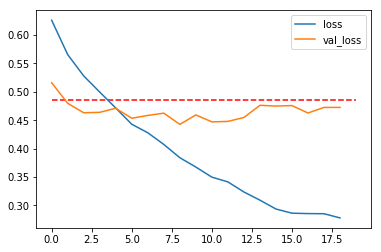

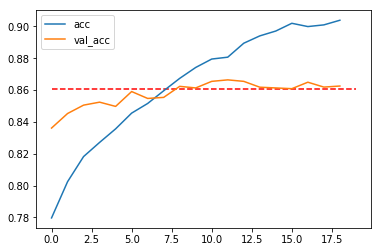

In [76]:

BATCH_SIZE = 100
score = model.evaluate_generator(test_generator.flow_from_directory('/home/crea/tf_env/test_imgs', 
                                                                  batch_size=BATCH_SIZE),
                                                                  ceil(len(x_test)/BATCH_SIZE),
                    
                        )
print(score)

#for k in ['val_acc', 'loss', 'val_loss', 'acc']:
#    with open('history_'+k+'.json', 'w') as f:
#        json.dump(history.history[k], f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
plt.hlines(score[0], 0, len(history.history['loss']), linestyle='--', color='r')
history_df[['acc', 'val_acc']].plot()
plt.hlines(score[1], 0, len(history.history['acc']), linestyle='--', color='r')

In [10]:
model = load_model('cifar10_F.h5')
BATCH_SIZE = 100
score = model.evaluate_generator(test_generator.flow_from_directory('/home/crea/tf_env/test_imgs', 
                                                                  batch_size=BATCH_SIZE),
                                                                  ceil(len(x_test)/BATCH_SIZE),
                    
                        )
print(score)
#history_df = pd.DataFrame(history.history)
#history_df[['loss', 'val_loss']].plot()
#plt.hlines(score[0], 0, len(history.history['loss']), linestyle='--', color='r')
#history_df[['acc', 'val_acc']].plot()
#plt.hlines(score[1], 0, len(history.history['acc']), linestyle='--', color='r')

Found 10000 images belonging to 10 classes.
[0.4560253711044788, 0.8616999965906144]


# UnFreeze ALL

In [12]:
K.clear_session()

resnet50_model = ResNet50(input_shape=(256, 256, 3), weights='imagenet', pooling='avg', include_top=False)
last_feature_map = resnet50_model.output

x = Dense(512, activation='relu')(last_feature_map)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(num_cls, activation='softmax')(x)
model = Model(inputs=[resnet50_model.input], outputs=[output_layer])
model = load_model('cifar10_F.h5')
#unfreeze partial pretrained parameter

for layer in model.layers:
    layer.trainable = True
    print('unfreeze:', layer)
model.summary()

unfreeze: <keras.engine.input_layer.InputLayer object at 0x7f8f6d8af390>
unfreeze: <keras.layers.convolutional.ZeroPadding2D object at 0x7f8f6d8afcf8>
unfreeze: <keras.layers.convolutional.Conv2D object at 0x7f8f6d8af9e8>
unfreeze: <keras.layers.normalization.BatchNormalization object at 0x7f8f6d8a8390>
unfreeze: <keras.layers.core.Activation object at 0x7f8f6d8a8d30>
unfreeze: <keras.layers.convolutional.ZeroPadding2D object at 0x7f8f6d8a8d68>
unfreeze: <keras.layers.pooling.MaxPooling2D object at 0x7f8f6d8a8f60>
unfreeze: <keras.layers.convolutional.Conv2D object at 0x7f8f6d8a8c50>
unfreeze: <keras.layers.normalization.BatchNormalization object at 0x7f8f6d8a8a58>
unfreeze: <keras.layers.core.Activation object at 0x7f8f6d8a89e8>
unfreeze: <keras.layers.convolutional.Conv2D object at 0x7f8f6d8a8dd8>
unfreeze: <keras.layers.normalization.BatchNormalization object at 0x7f8f6d8a8780>
unfreeze: <keras.layers.core.Activation object at 0x7f8f6d8a8ba8>
unfreeze: <keras.layers.convolutional.Co

In [13]:
BATCH_SIZE = 20
EPOCHS = 100
LEARNING_RATE = 1e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='cifar10_F.h5', 
                             save_best_only=True, verbose=1)

model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
history = model.fit_generator(train_generator.flow_from_directory('/home/crea/tf_env/train_imgs', 
                                                                  batch_size=BATCH_SIZE),
                                                      
                              epochs=EPOCHS, steps_per_epoch=ceil(len(x_train)/BATCH_SIZE),
                              validation_data= test_generator.flow_from_directory('/home/crea/tf_env/valid_imgs',
                                                                   batch_size=BATCH_SIZE),
                              validation_steps=ceil(len(x_valid)/BATCH_SIZE),
                              verbose=1, callbacks=[lr_reducer, early_stop, checkpoint],
                              shuffle=True)

Found 35000 images belonging to 10 classes.
Found 15000 images belonging to 10 classes.
Epoch 1/100
1750/1750 [==============================] - 381s 218ms/step - loss: 0.3271 - acc: 0.8857 - val_loss: 0.2242 - val_acc: 0.9225

Epoch 00001: val_loss improved from inf to 0.22420, saving model to cifar10_F.h5
Epoch 2/100
1750/1750 [==============================] - 392s 224ms/step - loss: 0.2480 - acc: 0.9149 - val_loss: 0.1790 - val_acc: 0.9411

Epoch 00002: val_loss improved from 0.22420 to 0.17899, saving model to cifar10_F.h5
Epoch 3/100
1750/1750 [==============================] - 402s 229ms/step - loss: 0.2014 - acc: 0.9307 - val_loss: 0.1569 - val_acc: 0.9470

Epoch 00003: val_loss improved from 0.17899 to 0.15687, saving model to cifar10_F.h5
Epoch 4/100
1750/1750 [==============================] - 404s 231ms/step - loss: 0.1631 - acc: 0.9455 - val_loss: 0.1570 - val_acc: 0.9491

Epoch 00004: val_loss did not improve from 0.15687
Epoch 5/100
1750/1750 [===========================

In [14]:
for idx, k in enumerate(['val_acc', 'loss', 'val_loss', 'acc']):
    with open('history_F.json', 'a') as f:
        json.dump({k:history.history[k]}, f)


Found 10000 images belonging to 10 classes.
[0.14630968816578388, 0.9586000055074692]


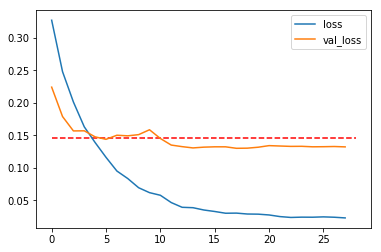

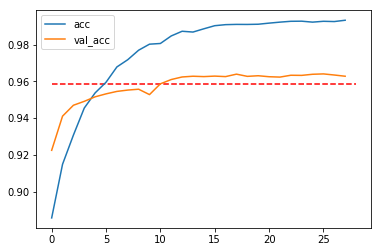

In [15]:

BATCH_SIZE = 100
score = model.evaluate_generator(test_generator.flow_from_directory('/home/crea/tf_env/test_imgs', 
                                                                  batch_size=BATCH_SIZE),
                                                                  ceil(len(x_test)/BATCH_SIZE),
                    
                        )
print(score)

#for k in ['val_acc', 'loss', 'val_loss', 'acc']:
#    with open('history_'+k+'.json', 'w') as f:
#        json.dump(history.history[k], f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
plt.hlines(score[0], 0, len(history.history['loss']), linestyle='--', color='r')
history_df[['acc', 'val_acc']].plot()
plt.hlines(score[1], 0, len(history.history['acc']), linestyle='--', color='r')